## Ventilator-Pressure-Prediction

### Install required packages

In [ ]:
!pip install -r requirement.txt

### Dataset download

The size of dataset is 440MB, so I uploaded it to Google drive. The following commnad is used to download the dataset and doing the feature 
engineering. And then the values of features will be scaled by a RobustScaler. Finally, the dataset will be splited into training set, validation 
set and testing set with a split ratio 2 : 1 : 1.  It takes around 3-4 minutes to complete.

In [ ]:
!python main.py --dataset_download

After this command, you will find there are 7 csv files in ./data

* dataset.csv: the original dataset

* train.csv, val.csv, test.csv: The three datasets without feature engineering

* trainFE.csv, valFE.csv, testFE.csv: The three datasets after feature engineering

As for How I doing the feature engineering:

* The code is available in ./utils/feature_eng.py

* The formular is available in report

### EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import polyfit, poly1d
from utils.loss import criterion
random_state = 9999

In [2]:
# load data
df = pd.read_csv('data/dataset.csv')
print(f'The total records of the dataset: {df.shape[0]}')
print(f'The total breathes of the dataset: {df.breath_id.nunique()}')
print(f'The number of steps for each breathe: {df.shape[0] / df.breath_id.nunique()}')

df.head()

The total records of the dataset: 6036000
The total breathes of the dataset: 75450
The number of steps for each breathe: 80.0


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


#### Time Plot

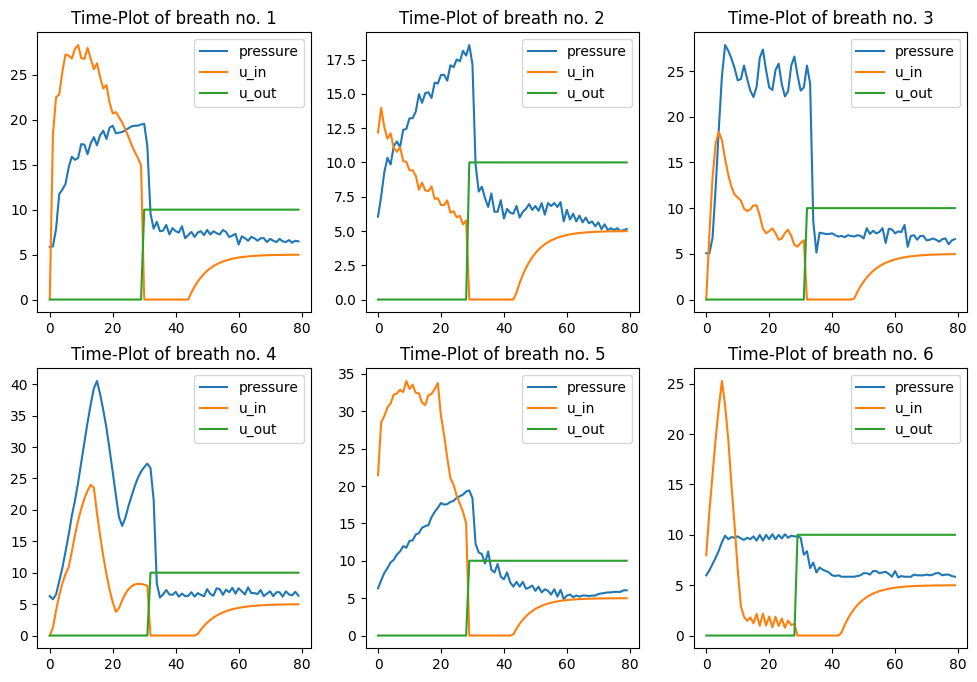

In [3]:
plt.figure(figsize=(12,8))
for i in range(1,7):
    plt.subplot(2,3,i)
    pressure = df[df['breath_id']==i]['pressure']
    u_in = df[df['breath_id']==i]['u_in']
    u_out = df[df['breath_id']==i]['u_out'] * 10
    plt.plot(range(len(pressure)),pressure,label='pressure')
    plt.plot(range(len(u_in)),u_in,label='u_in')
    plt.plot(range(len(u_out)),u_out,label='u_out')
    plt.title(f'Time-Plot of breath no. {i}')
    plt.legend()

plt.show()

#### Single Variable

50    2410080
5     1988800
20    1637120
Name: R, dtype: int64


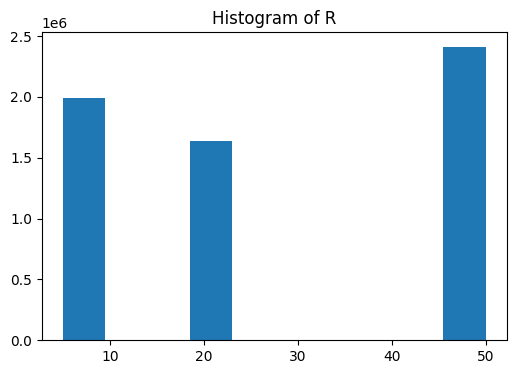

In [4]:
Rs = df['R']
print(Rs.value_counts())

plt.figure(figsize=(6,4))
plt.hist(Rs)
plt.title('Histogram of R')
plt.show()

10    2244720
50    1971680
20    1819600
Name: C, dtype: int64


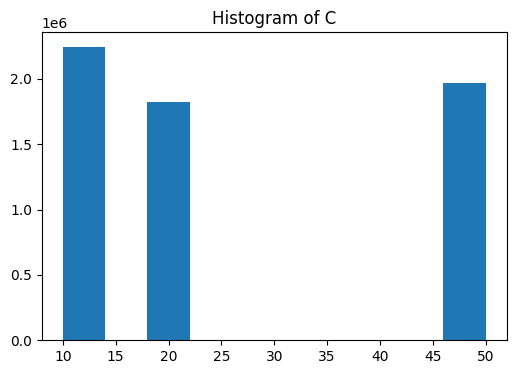

In [5]:
Cs = df['C']
print(Cs.value_counts())

plt.figure(figsize=(6,4))
plt.hist(Cs)
plt.title('Histogram of C')
plt.show()

0.0    1432253
Name: u_in, dtype: int64


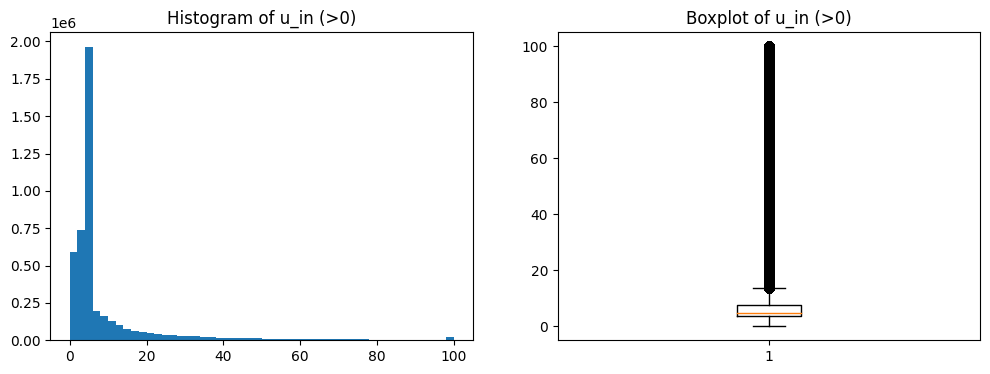

In [6]:
u_ins = df['u_in']
u_ins_0 = df[df['u_in'] == 0]['u_in']
u_ins_pos = df[df['u_in']>0]['u_in']
print(u_ins_0.value_counts())

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(u_ins_pos,bins=50)
plt.title('Histogram of u_in (>0)')

plt.subplot(1,2,2)
plt.boxplot(u_ins_pos)
plt.title('Boxplot of u_in (>0)')
plt.show()

In [7]:
u_outs = df['u_out']
u_outs.value_counts()

1    3745032
0    2290968
Name: u_out, dtype: int64

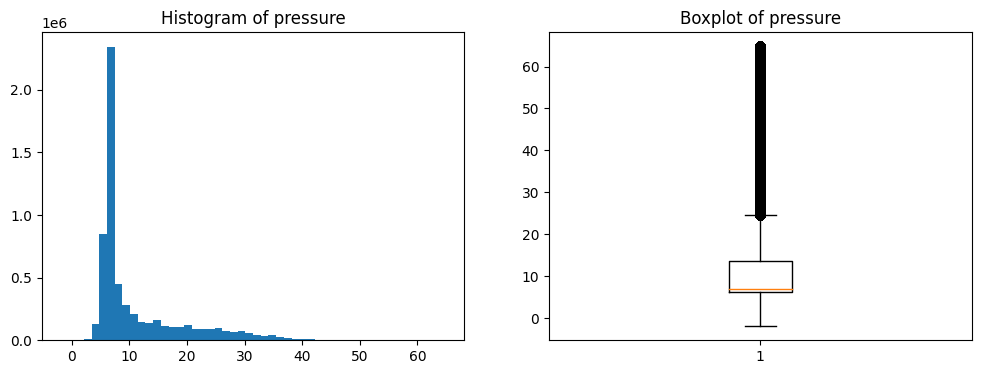

In [8]:
p = df['pressure']

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(p,bins=50)
plt.title('Histogram of pressure')

plt.subplot(1,2,2)
plt.boxplot(p)
plt.title('Boxplot of pressure')
plt.show()

#### Correlation vector

In [9]:
corr_vec = df.corr()
corr_vec

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


### Baseline -- Random Guess


#### Within_breath fit

In [10]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
print(train.head())

          R     C  time_step       u_in  u_out   pressure
0 -0.333333  0.75  -0.989052   0.068743   -1.0   5.415679
1 -0.333333  0.75  -0.963582  20.829850   -1.0   6.189002
2 -0.333333  0.75  -0.937700  20.829850   -1.0  11.672570
3 -0.333333  0.75  -0.911946  20.221291   -1.0  15.257979
4 -0.333333  0.75  -0.886145  19.745430   -1.0  16.593720


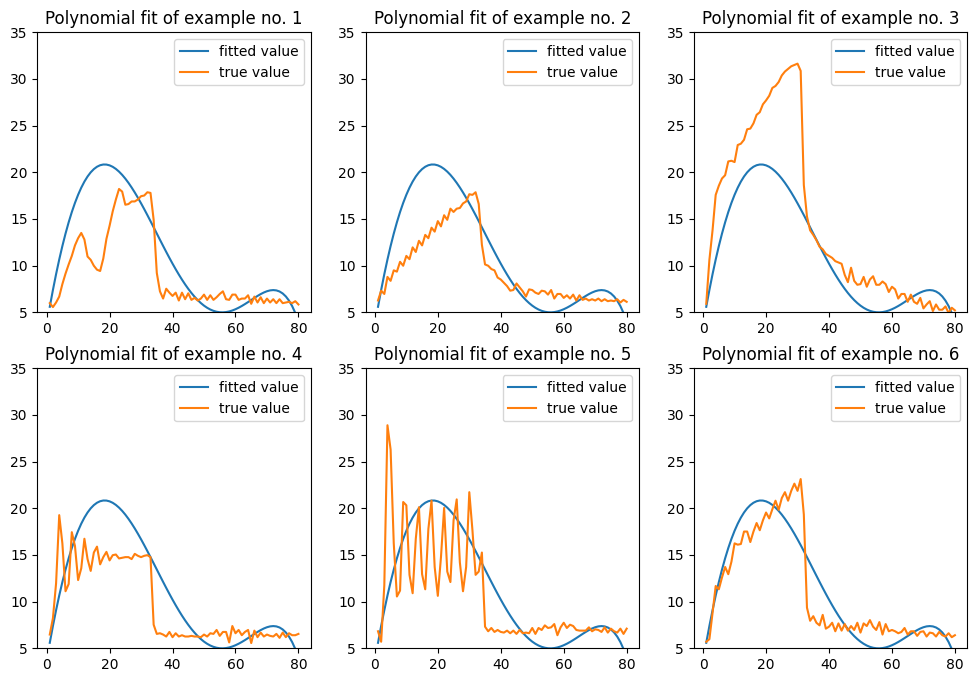

In [11]:
np.random.seed(random_state)

# calculate the mean of target sequence in training set
train_seq = train['pressure'].values.reshape(-1,80)
train_mean = np.average(train_seq,axis=0)

# fit the mean of training set via polynomial
poly_degree = 5

plt.figure(figsize=(12,8))
for i in range(1,7):
    plt.subplot(2,3,i)

    x = np.arange(1,81)
    target = train_seq[i]

    # polynomial fit
    y = poly1d(polyfit(x, train_mean, poly_degree))
    plt.plot(x, y(x), label='fitted value')
    plt.plot(x, target, label='true value')
    plt.ylim((5,35))
    plt.title(f'Polynomial fit of example no. {i}') # the order of breath_id in training set is shuffled
    plt.legend()

plt.show()

In [12]:
np.random.seed(random_state)

def witnin_guess(seq=train_mean, poly_degree=5):
    x = np.arange(1,81)
    y = poly1d(polyfit(x, seq, poly_degree))
    guess = y(x)

    return guess


#### Between-breath Guess

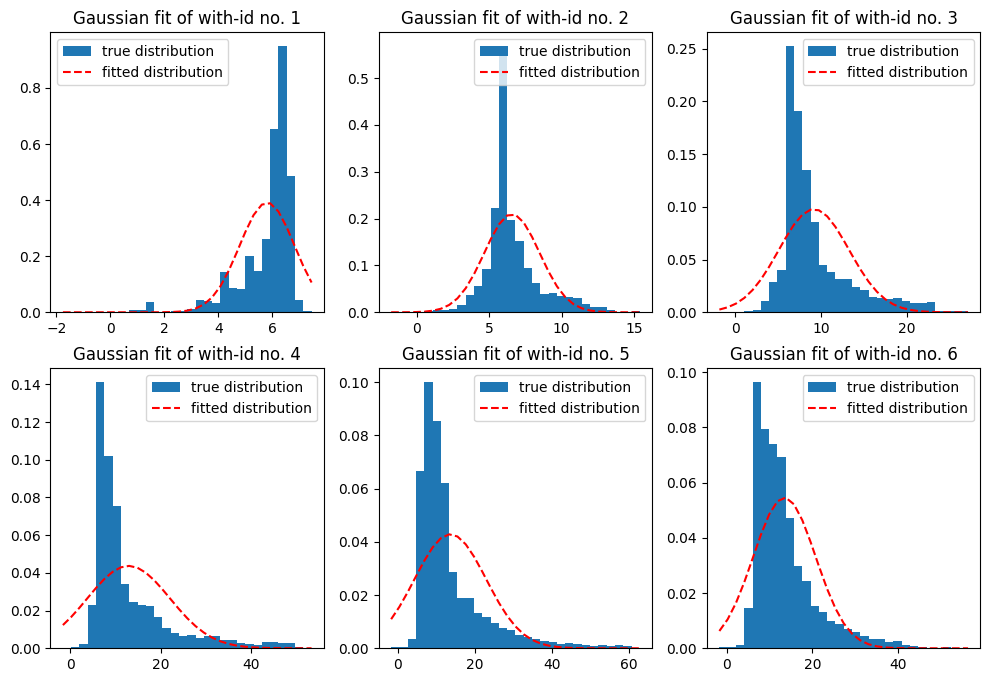

In [13]:
plt.figure(figsize=(12,8))

for i in range(1,7):
    plt.subplot(2,3,i)
    breath_target = train[(train.index+1) % 80 == i]['pressure']
    n, bins, patches = plt.hist(breath_target,bins=30,density=True,label='true distribution')
    mu = np.mean(breath_target)
    sigma = np.std(breath_target,ddof=True)
    y = stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--', label='fitted distribution')
    plt.title(f'Gaussian fit of with-id no. {i}') # the order of breath_id in training set is shuffled
    plt.legend()

plt.show()

### Modelling

We don't our models fitting here because it cost a lot of time and the printed information is too much (not suitable for reading), but we upload the parameters for each model which has the best performance in .runs/model_name/model.pkl or model.pt

#### LinearRegression without Feature Engineering

In [14]:
!python main.py --do_train_eval --model_name LinearRegression

05/07/2023 15:52:02 - INFO - logger -    Fitting LinearRegression model without feature engineering
05/07/2023 15:52:03 - INFO - logger -    Evaluating LinearRegression model
05/07/2023 15:52:04 - INFO - logger -    Saving the evaluation result to ./runs/LinearRegression/eval_results.csv:
{

    R-Square: 0.3845827740113189

    MSE: 40.333762650574315

    MAE: 3.9371698485641993

    MAPE: 0.48754022121091767

    SMAPE: 0.29450728591530967

}

05/07/2023 15:52:04 - INFO - logger -    Saving the best model to ./runs/LinearRegression/model.pkl


#### LinearRegression with features after Feature Engineering 

In [15]:
!python main.py --do_train_eval --model_name LinearRegression --is_feature_eng

05/07/2023 15:52:08 - INFO - logger -    Fitting LinearRegression model after feature engineering
05/07/2023 15:52:20 - INFO - logger -    Evaluating LinearRegression model
05/07/2023 15:52:24 - INFO - logger -    Adding the evaluation result to ./runs/LinearRegression/eval_results.csv:
{

    R-Square: 0.682170902615796

    MSE: 20.83016665116313

    MAE: 3.1715533443538195

    MAPE: 0.4222630634150285

    SMAPE: 0.30011590763688223

}

05/07/2023 15:52:24 - INFO - logger -    Saving the best model to ./runs/LinearRegression/model.pkl


#### Decision tree with grid search

* max_depth: range from 5 - 20 with step 1

* min_samples_leaf: 2

* The Criterion on both training set and validation set will be saved to ./runs/DecisionTree/train_results.csv and eval_results.csv respectively

* The best model with the smallest MAE will be saved to ./runs/DecisionTree/model.pkl

In [ ]:
!python grid_search.py --model_name DecisionTree --is_feature_eng

#### Random Forest with grid search

* max_depth: range from 5 - 20 with step 1

* min_samples_leaf: 2

* n_estimators: 10, 50, 100

* Sample ratio: 0.05

* The Criterion on both training set and validation set will be saved to ./runs/RandomForest/train_results.csv and eval_results.csv respectively

* The best model with the smallest MAE will be saved to ./runs/RandomForest/model.pkl

In [ ]:
!python grid_search.py --model_name RandomForest --is_feature_eng

#### xgboost with grid search

* max_depth: range from 5 - 15 with step 1

* min_samples_leaf: 2

* n_estimators: 10, 50, 100

* Sample ratio: 0.05

* The Criterion on both training set and validation set will be saved to ./runs/DecisionTree/train_results.csv and eval_results.csv respectively

* The best model with the smallest MAE will be saved to ./runs/xgboost/model.pkl

In [ ]:
!python grid_search.py --model_name xgboost --is_feature_eng

#### MLP

Start from here, GPU is sugguseted, but it's ok if you don't have one

**Option I:**

Like the meachine learning models, just fit the model by the tabular data: (batch_size, n_features)

* learning rate: 5e-5

* batch_size: 16392 (about 180 iterations in 1 epoch)

* weight_decay: 0

* num_epochs: 50

* gamma: learning scheduler decay factor, 0.95

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/mlp_tabular/model.pt

* The training loss and validation loss during the training process will be saved to .runs/mlp_tabular/train.csv

In [ ]:
!python main.py --do_train_eval --model_name mlp_tabular --is_feature_eng

**Option II:**

Treat a whole sequence as an sample: (batch_size, sequence_length, n_features)

* learning rate: 5e-5

* batch_size: 256 (about 150 iterations in 1 epoch)

* weight_decay: 0

* num_epochs: 50

* gamma: learning scheduler decay factor, 0.95

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/mlp_sequence/model.pt

* The training loss and validation loss during the training process will be saved to .runs/mlp_sequence/train.csv

In [ ]:
!python main.py --do_train_eval --model_name mlp_sequence --is_feature_eng

#### CNN

Treat a whole sequence as an sample: (batch_size, sequence_length, n_features)

**Option I:**

Basic CNN model, there will be no residual connection

* learning rate: 5e-5

* batch_size: 256 (about 150 iterations in 1 epoch)

* weight_decay: 0

* num_epochs: 50

* gamma: learning scheduler decay factor, 0.95

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/cnn/model.pt

* The training loss and validation loss during the training process will be saved to .runs/cnn/train.csv

!python main.py --do_train_eval --model_name cnn

**Option II:**

CNN model with residual connection, the hyperparameters are the same as before

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/cnn_residual/model.pt

* The training loss and validation loss during the training process will be saved to .runs/cnn_residual/train.csv

In [ ]:
!python main.py --do_train_eval --model_name cnn_residual --is_feature_eng

#### RNN

**Option I:**

Basic RNN, treat a whole sequence as an sample: (batch_size, sequence_length, n_features)

* learning rate: 5e-5

* batch_size: 256 (about 150 iterations in 1 epoch)

* weight_decay: 0

* num_epochs: 50

* gamma: learning scheduler decay factor, 0.95

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/rnn/model.pt

* The training loss and validation loss during the training process will be saved to .runs/rnn/train.csv

In [ ]:
!python main.py --do_train_eval --model_name rnn --is_feature_eng

**Option II:**

LSTM, still treat a whole sequence as an sample: (batch_size, sequence_length, n_features)

The hyperparameters are the same as before

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/lstm/model.pt

* The training loss and validation loss during the training process will be saved to .runs/lstm/train.csv

In [ ]:
!python main.py --do_train_eval --model_name lstm --is_feature_eng

**Option III:**

GRU, still treat a whole sequence as an sample: (batch_size, sequence_length, n_features)

The hyperparameters are the same as before

* The best model which has the smallest MSE on validation set during the training process will be saved to .runs/gru/model.pt

* The training loss and validation loss during the training process will be saved to .runs/gru/train.csv

In [ ]:
!python main.py --do_train_eval --model_name gru --is_feature_eng

### Generalizability test for the best model

You can find the comparisons of different models in our report, our selected model is mlp_sequence model and now we test its generalizability on the testing set

In [16]:
!python main.py --do_pred --model_name mlp_sequence --is_feature_eng

05/07/2023 15:59:49 - INFO - logger -    Evaluating mlp_sequence model on the testing set
100%|███████████████████████████████████████████| 74/74 [00:01<00:00, 39.09it/s]
validation loss:  0.3988211154937744
{

    Rsquared: 0.9939281344413757

    MSE: 0.3988211154937744

    MAE: 0.3853650391101837

    MAPE: 0.05037606507539749

    SMAPE: 0.03758680075407028

}

